## XGBoost (eXtreme Gradient Boosting) 
**XGBoost is a powerful machine learning algorithm used in crop prediction systems to recommend the most suitable crop based on factors such as soil properties, weather conditions, and nutrient requirements. It learns patterns from historical data and helps make informed decisions for optimal crop growth.**

In [1]:
# Import necessary libraries
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
data = pd.read_csv('Crop_recommendation.csv')

## Data Wrangling

In [3]:
# Check for null values
print(data.isnull().sum())

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


We checked there are no null values in our dataset, so we don't need to impute or drop any columns.

In [4]:
# Rename Columns
data = data.rename(columns={'N': 'Nitrogen', 'P': 'Phosphorus', 'K': 'Potassium', 
                            'temperature': 'Temperature', 'humidity': 'Humidity', 'ph': 'pH', 
                            'rainfall': 'Rainfall', 'label': 'Crop'})


In [5]:
# Capitalizing the first letter of column name
data.columns = data.columns.str.capitalize()

## Data Exploration

In [6]:
# checking the top 5 rows
data.head()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,Ph,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
# checking bottom rows
data.tail()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,Ph,Rainfall,Crop
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee
2199,104,18,30,23.603016,60.396475,6.779833,140.937041,coffee


In [8]:
# checking the data types
data.dtypes

Nitrogen         int64
Phosphorus       int64
Potassium        int64
Temperature    float64
Humidity       float64
Ph             float64
Rainfall       float64
Crop            object
dtype: object

## Data Visualization

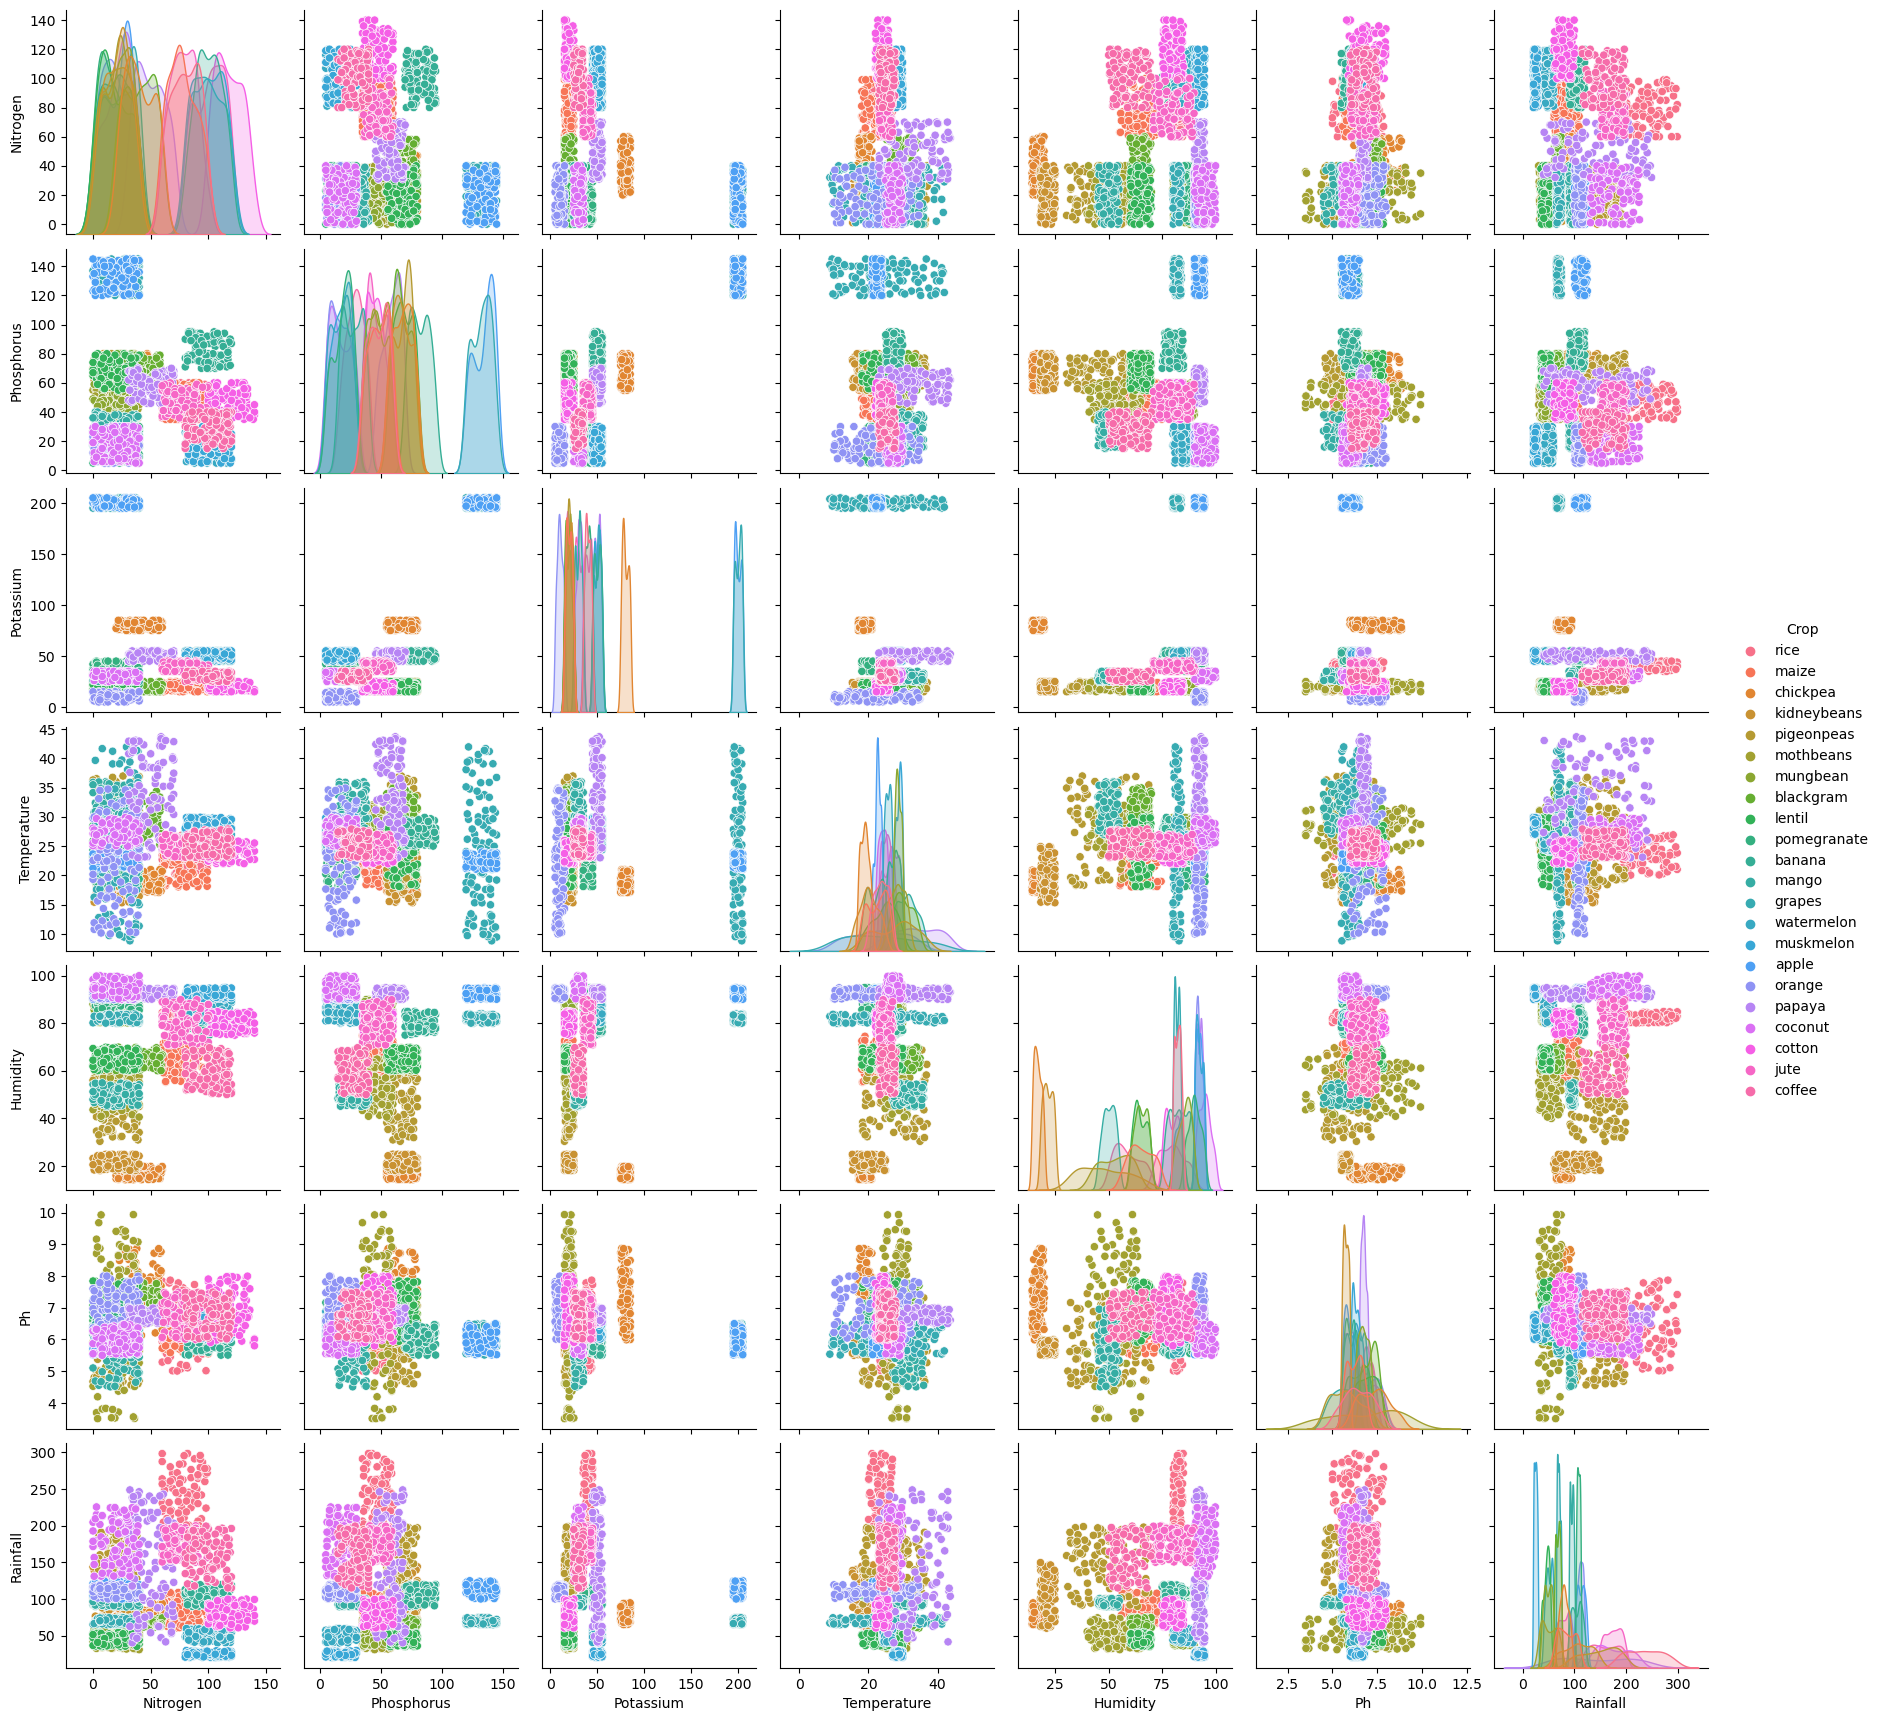

In [9]:
# Pairplot to visualize relationships between features
sns.pairplot(data, hue='Crop')
plt.show()

In [10]:
data.corr()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,Ph,Rainfall
Nitrogen,1.000000,-0.231460,-0.140512,0.026504,0.190688,0.096683,0.059020
Phosphorus,-0.231460,1.000000,0.736232,-0.127541,-0.118734,-0.138019,-0.063839
Potassium,-0.140512,0.736232,1.000000,-0.160387,0.190859,-0.169503,-0.053461
Temperature,0.026504,-0.127541,-0.160387,1.000000,0.205320,-0.017795,-0.030084
Humidity,0.190688,-0.118734,0.190859,0.205320,1.000000,-0.008483,0.094423
Ph,0.096683,-0.138019,-0.169503,-0.017795,-0.008483,1.000000,-0.109069
Rainfall,0.059020,-0.063839,-0.053461,-0.030084,0.094423,-0.109069,1.000000


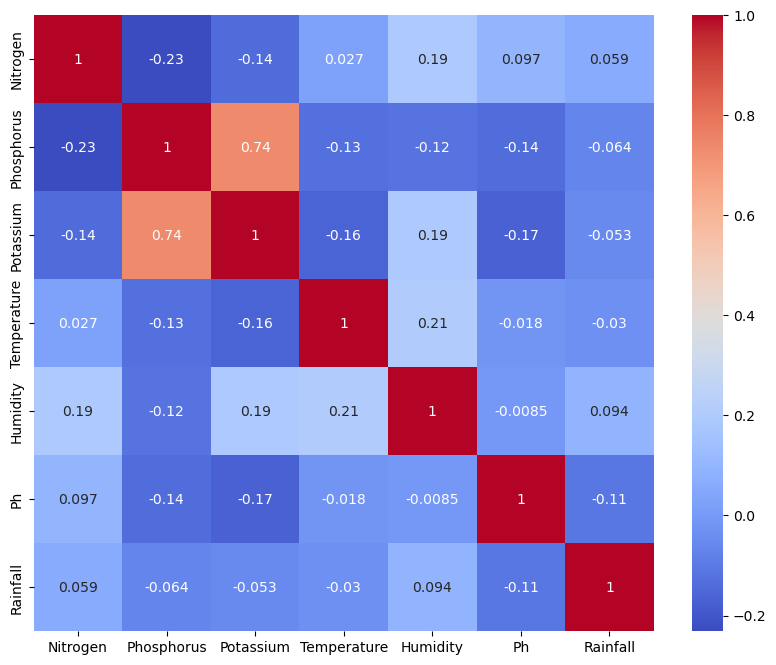

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.show()

## Model Training and Evaluation

In [12]:
# Encode the labels as integers
label_encoder = LabelEncoder()
data['Crop'] = label_encoder.fit_transform(data['Crop'])

In [13]:
# Create a list of crop names
crop_list = label_encoder.classes_
print('Crop List:', crop_list)

Crop List: ['apple' 'banana' 'blackgram' 'chickpea' 'coconut' 'coffee' 'cotton'
 'grapes' 'jute' 'kidneybeans' 'lentil' 'maize' 'mango' 'mothbeans'
 'mungbean' 'muskmelon' 'orange' 'papaya' 'pigeonpeas' 'pomegranate'
 'rice' 'watermelon']


In [14]:
# Split dataset into features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values


In [15]:
# Split dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# Create the DMatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)


In [17]:
# Define the hyperparameters
params = {
    'objective': 'multi:softmax', # Specify the objective function
    'num_class': len(set(y_train)), # Specify the number of classes
    'eta': 0.1, # Learning rate
    'max_depth': 6, # Maximum depth of the tree (increase to reduce overfitting)
    'verbosity': 0, # Set the level of information printed during training
    'subsample': 0.7, # Subsample ratio of the training instances (increase to reduce overfitting)
    'colsample_bytree': 0.7, # Subsample ratio of columns when constructing each tree (increase to reduce overfitting)
    'alpha': 1, # L1 regularization parameter (Lasso)
    'lambda': 1, # L2 regularization parameter (Ridge)
}

In [18]:
# Train the model
num_rounds = 50
model = xgb.train(params, dtrain, num_rounds)

In [19]:
# Predict the test results
y_pred = model.predict(dtest)

## Model Evaluation and Performance Metrics

In [20]:
# Calculate the accuracy, confusion matrix, and classification report
accuracy = accuracy_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [21]:
#checking the accuracy of the model
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", classification_rep)

Accuracy: 0.9954545454545455
Confusion Matrix:
 [[18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 22  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 16  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 21  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 25  0  0  0  0

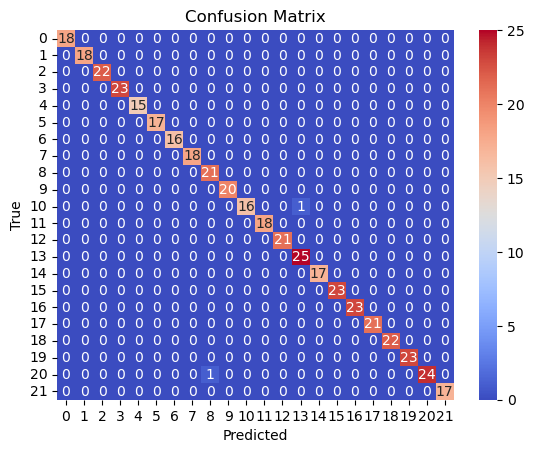

In [22]:
#Create a heatmap of the confusion matrix
sns.heatmap(confusion_mat, annot=True, cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

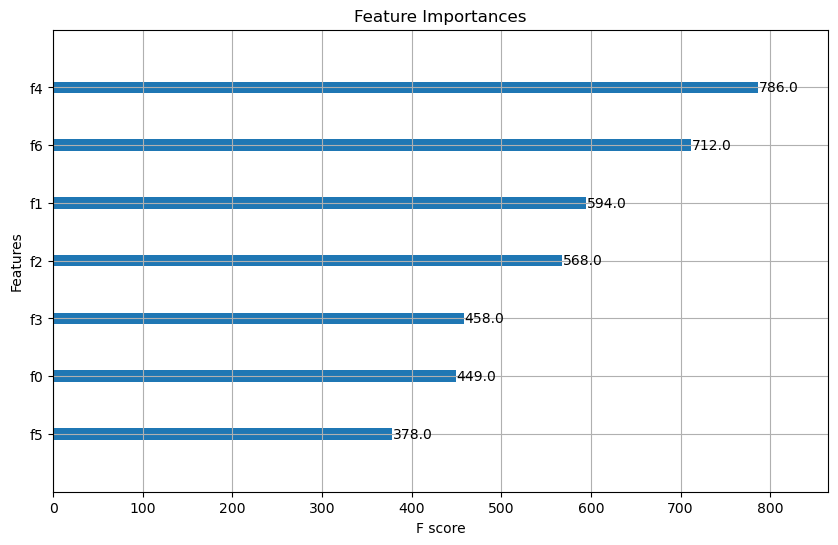

In [23]:
#Plot the feature importances
fig, ax = plt.subplots(figsize=(10,6))
xgb.plot_importance(model, ax=ax)
plt.title('Feature Importances')
plt.show()

## Model Serialization and Deserialization

**Pickle approach**

In [24]:
import pickle

In [25]:
# Save the model to a pickle file
with open('crop_recommendation_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [26]:
# Load the model from the pickle file
with open('crop_recommendation_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [27]:
# Use the loaded model to make predictions
dtest = xgb.DMatrix(X_test)
y_pred_loaded = loaded_model.predict(dtest)

In [28]:
# Check if the predictions made by the loaded model are the same as the original model
assert (y_pred == y_pred_loaded).all(), "Loaded model predictions do not match original model predictions"